<a href="https://colab.research.google.com/github/PawelJakubczyk/Manufacturing-Revenue-for-EU-Export/blob/main/manage_manufacturing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instal library

In [73]:
%pip install pyspark
%pip install importnb

# Utilities

In [74]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DateType, IntegerType, FloatType
from datetime import datetime
import matplotlib.pyplot as plt

product_schema = StructType([
    StructField("Product_ID", StringType(), nullable=True),
    StructField("Subsector", StringType(), nullable=True),
    StructField("Category", StringType(), nullable=True),
    StructField("Brand", StringType(), nullable=True),
    StructField("Material_ID", IntegerType(), nullable=True),
    StructField("Description", StringType(), nullable=True),
    StructField("Weight", FloatType(), nullable=True),
    StructField("Shelf_Life", IntegerType(), nullable=True),
    StructField("Supplier_ID", IntegerType(), nullable=True)
])

transaction_schema = StructType([
    StructField("Supplier_ID", IntegerType(), nullable=False),
    StructField("Countries_of_Sale", StringType(), nullable=False),
    StructField("Transaction_ID", StringType(), nullable=False),
    StructField("Sales_Initiation_Date", DateType(), True),
    StructField("Sales_End_Date", DateType(), True),
    StructField("Product_ID", StringType(), True),
])


financial_schema = StructType([
    StructField("Transaction_ID", StringType(), nullable=False),
    StructField("Profit_YTD", FloatType(), nullable=False),
    StructField("Profit_Last_2_Years", FloatType(), nullable=False),
    StructField("Profit_Last_Year", FloatType(), nullable=False),
    StructField("Profit_Last_Month", FloatType(), nullable=False),
    StructField("Profit_Last_Week", FloatType(), nullable=False),
    StructField("Market_Value", FloatType(), nullable=False)
])

eu_countries_mapping_schema = StructType([
    StructField("Country", StringType(), True),
    StructField("Country_Code", StringType(), True)
])

suplier_mapping_schema = StructType([
    StructField("Supplier_ID", IntegerType(), True),
    StructField("Supplier_Name", StringType(), True),
    StructField("Country_of_Distribution", StringType(), True),
])

eu_mapping_path = '/mapping/eu_mapping.csv'
suplier_mapping_path = '/mapping/suplier_mapping.csv'
financials_path = '/data/financials.csv'
products_path = '/data/products.csv'
supliers_path = '/data/supliers.csv'
transactions_path = '/data/transactions.csv'

output_path_product_missing = "/data_discrepancies/missing_product_data_eu.csv"
output_path_transactions_missing = "/data_discrepancies/missing_transaction_data_eu.csv"

# Import library & star session

In [75]:
from importnb import Notebook
# with Notebook('utilities.ipynb'):
#     from utilities import (product_schema,
#                            suplier_schema,
#                            transaction_schema,
#                            financial_schema,
#                            eu_countries_schema,
#                            eu_mapping_path,
#                            suplier_mapping_path,
#                            financials_path,
#                            products_path,
#                            supliers_path,
#                            transactions_path
#                            output_path_product_missing
#                            output_path_transactions_missing
#                            )
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DateType, IntegerType, FloatType
from datetime import datetime
from random import choice, uniform, randint, seed

# Create a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Data Procesing

### Read data from csv

In [85]:
df_transactions = spark.read.csv(transactions_path, schema=transaction_schema, header=True, inferSchema=True)
df_eu_mapping = spark.read.csv(eu_mapping_path, schema=eu_countries_mapping_schema, header=True, inferSchema=True)

### Countries_of_Sale EU rule: Limit data to EU countries

In [86]:
df_transactions_of_sale_eu = df_transactions.join(df_eu_mapping, df_transactions["Countries_of_Sale"] == df_eu_mapping["Country"], "inner")


In [87]:
df_transactions_of_sale_eu.show()

count_matching_countries = df_transactions_of_sale_eu.count()
count_non_matching_countries = df_transactions.count() - count_matching_countries

+-----------+-----------------+--------------------+---------------------+--------------+----------+----------+------------+
|Supplier_ID|Countries_of_Sale|      Transaction_ID|Sales_Initiation_Date|Sales_End_Date|Product_ID|   Country|Country_Code|
+-----------+-----------------+--------------------+---------------------+--------------+----------+----------+------------+
|         17|          Croatia|0001b030-060d-456...|           2025-01-08|          NULL|      1058|   Croatia|          HR|
|         13|            Malta|0007d734-0518-4f2...|           2015-04-14|    2023-08-02|      1919|     Malta|          MT|
|         10|         Portugal|000a7188-9fcf-433...|           2018-10-23|    2020-10-31|      1741|  Portugal|          PT|
|         14|          Croatia|000c1d2c-2eb0-46a...|           2028-07-16|    2029-05-31|      1467|   Croatia|          HR|
|         26|          Romania|000ccdca-e37b-476...|           2020-11-06|    2030-01-17|      1472|   Romania|          RO|


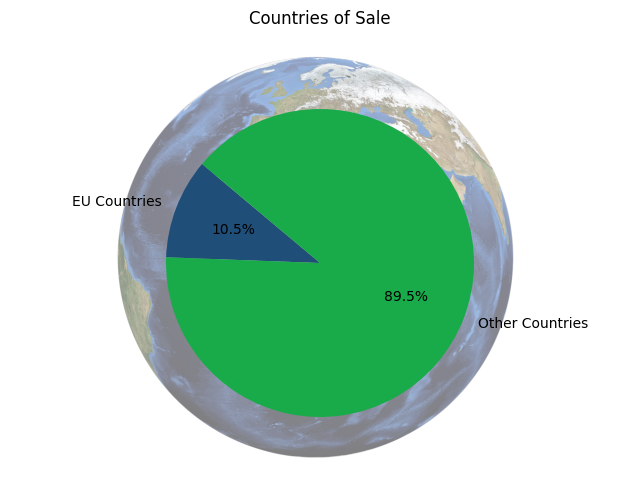

In [88]:
# Loading PNG images
world_map_img = plt.imread('/png/world_map.png')

# Data for the plot
labels = ['EU Countries', 'Other Countries']
sizes = [count_matching_countries, count_non_matching_countries]

# Define colors for the pie chart
colors = ['#1F4E78', '#19AB4A']

# Creating a pie chart with specified colors and PNG images as background
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)

# Adding the world map image as background for the second slice
ax.imshow(world_map_img, extent=(-1.5, 1.5, -1.5, 1.5), aspect='auto', alpha=0.5)

# Setting the title of the plot
plt.title('Countries of Sale')

# Displaying the plot
plt.axis('equal')
plt.show()

In [90]:
df_products = spark.read.csv(products_path, schema=product_schema, header=True, inferSchema=True)
df_products = df_products.drop('Material_ID')
df_products = df_products.drop('Weight')
df_products = df_products.drop('Shelf_Life')

In [91]:
df_products.show()

+--------------------+--------------------+-----------+--------+--------------------+-----------+
|          Product_ID|           Subsector|   Category|   Brand|         Description|Supplier_ID|
+--------------------+--------------------+-----------+--------+--------------------+-----------+
|                1000|       Dessert Mixes|       Tart|  Zypher|Understand good n...|         12|
|                1001|       Dessert Mixes|        Pie|  Zypher|That religious fo...|         13|
|                1002|     Bakery Supplies|    Gumdrop|  Nexxon|Up dog gun these....|         21|
|                1003|          Sweeteners|      Creme| Vintura|Age attention awa...|         23|
|                1004|          Sweeteners|     Bakery|  Zypher|Music partner mon...|         15|
|                1005|          Sweeteners|Marshmallow|  Aurora|Political nothing...|         23|
|                1006|          Sweeteners|    Caramel|Exquinox|Economic always a...|       NULL|
|What try event ch..

In [92]:
df_produt_with_transactions_eu = df_transactions_of_sale_eu.join(df_products, on="Product_ID", how="inner")
df_product_id_missing_in_product_eu = df_transactions_of_sale_eu.join(df_products, on="Product_ID", how="left_anti")
df_product_id_missing_in_transactions_eu = df_products.join(df_transactions_of_sale_eu, on="Product_ID", how="left_anti")

# Save df_product_id_missing_in_product_eu to CSV
df_product_id_missing_in_product_eu.write.csv(output_path_product_missing, header=True, mode="overwrite")
# Save df_product_id_missing_in_transactions_eu to CSV
df_product_id_missing_in_transactions_eu.write.csv(output_path_transactions_missing, header=True, mode="overwrite")

In [93]:
df_produt_with_transactions_eu.show()

+----------+-----------+-----------------+--------------------+---------------------+--------------+----------+------------+--------------------+-------------+--------+--------------------+-----------+
|Product_ID|Supplier_ID|Countries_of_Sale|      Transaction_ID|Sales_Initiation_Date|Sales_End_Date|   Country|Country_Code|           Subsector|     Category|   Brand|         Description|Supplier_ID|
+----------+-----------+-----------------+--------------------+---------------------+--------------+----------+------------+--------------------+-------------+--------+--------------------+-----------+
|      1058|         17|          Croatia|0001b030-060d-456...|           2025-01-08|          NULL|   Croatia|          HR|          Sweeteners|        Treat|  Zypher|Material morning ...|         27|
|      1919|         13|            Malta|0007d734-0518-4f2...|           2015-04-14|    2023-08-02|     Malta|          MT|     Packaged Sweets|       Cookie|Exquinox| Daughter deep ever.|   

In [ ]:
# Define the DataFrames and their counts
dataframes = ['df_produt_with_transactions_eu', 'df_product_id_missing_in_product_eu', 'df_product_id_missing_in_transactions_eu']
counts = [df.count() for df in [df_produt_with_transactions_eu, df_product_id_missing_in_product_eu, df_product_id_missing_in_transactions_eu]]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(dataframes, counts, color=['blue', 'orange', 'green'])
plt.xlabel('DataFrames')
plt.ylabel('Counts')
plt.title('Counts in Different DataFrames')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
del df_product_id_missing_in_product_eu
del df_product_id_missing_in_transactions_eu

In [ ]:
df_supliers = spark.read.csv(supliers_path, schema=suplier_mapping_schema, header=True, inferSchema=True)
df_eu_mapping = spark.read.csv(eu_mapping_path, schema=eu_countries_mapping_schema, header=True, inferSchema=True)
df_financials = spark.read.csv(financials_path, schema=financial_schema, header=True, inferSchema=True)

In [ ]:
df_products = spark.read.csv(products_path, schema=product_schema, header=True, inferSchema=True)

df_produt_with_transactions_eu = df_transactions_of_sale_eu.join(df_products, on="Product_ID", how="inner")
df_product_id_missing_in_product_eu = df_transactions_of_sale_eu.join(df_products, on="Product_ID", how="left_anti")
df_product_id_missing_in_transactions_eu = df_products.join(df_transactions_of_sale_eu, on="Product_ID", how="left_anti")